# Import thư viện


In [1]:
from underthesea import word_tokenize
import pandas as pd
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# Thu thập dữ liệu

**Tổng quan**
> Tin giả đang là một vấn đề nhức nhối của xã hội, đặc biệt trong thời đại bùng nổ
thông tin hiện nay. Đồ án này sẽ cho phép các bạn làm việc với dữ liệu văn bản tiếng
Việt, xây dựng mô hình dự đoán tin giả và deploy mô hình này lên một trang web đơn
giản.

**Chi tiết**
> Nguồn dữ liệu: VNFD Dataset\
    - Tập dữ liệu 223 record bản tin tiếng Việt, gồm 2 nhãn: 1 (tin giả) và 0 (tin thật)\
    - Mô tả dữ liệu: [Mô tả tập VNFD](https://github.com/thanhhocse96/vfnd-vietnamese-fake-news-datasets/tree/master/CSV)

# Khám phá dữ liệu

## Đọc dữ liệu vào

In [2]:
data = pd.read_csv("dataset_raw.csv")

* hiển thị vài dòng đầu & vài dòng cuối để xem sét.

In [3]:
data.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\r...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


In [4]:
data.tail()

,text,domain,label
218,“Siêu máy bay” A350 sẽ chở CĐV Việt Nam đi Mal...,dantri.com.vn,0
219,Thưởng 20.000 USD cho đội tuyển cờ vua Việt Na...,dantri.com.vn,0
220,Trường Sơn giành HCV tại giải cờ vua đồng đội ...,dantri.com.vn,0
221,Chuyện về chàng sinh viên Luật - Kiện tướng Lê...,dantri.com.vn,0
222,Tiền đạo Malaysia: “Tôi đã có cách vượt qua hà...,dantri.com.vn,0


## Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [5]:
nrows, ncols = data.shape

In [6]:
print("Dataset have {} rows and {} columns".format(nrows, ncols))

Dataset have 223 rows and 3 columns


## Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

- Mỗi record dữ liệu bao gồm 2 trường Text và Label. Text tổng hợp từ các tin tức giả và thật từ Facebook và Báo chí, tin tức báo chí sẽ bao gồm phần tiêu đề và nội dung.\
$\to$ nhìn chung thì các dòng đều có chung ý nghĩa.

## Dữ liệu có các dòng bị lặp không?

In [7]:
n_duplicated_rows = data.duplicated().sum()

print("Dataset have {} duplicated rows".format(n_duplicated_rows))

Dataset have 1 duplicated rows


$\to$ có 1 dòng bị trùng nên phải xóa dòng đó đi.

----

# Tiền xử lý

In [8]:
data.drop_duplicates(inplace=True)

Xem lại tập dữ liệu

In [9]:
n_duplicated_rows = data.duplicated().sum()

print("Dataset after deleted {} duplicated rows".format(n_duplicated_rows))

Dataset after deleted 0 duplicated rows


# Quay lại khám phá dữ liệu

## Mỗi cột có ý nghĩa gì?

|column|meaning|
|-|-|
|text|dữ liệu dạng văn bản là 1 bản tin hay 1 bài báo nào đó|
|domain|nguồn của văn bản này|
|label|1 nếu đó là tin giả, 0 nếu đó là tin thật|

## Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [10]:
data.dtypes.to_frame()

,0
text,object
domain,object
label,int64


$\to$ các cột đều mang đúng kiểu dữ liệu của nó.

## Số-lượng/tỉ-lệ các giá trị thiếu?

In [11]:
data.isna().sum()

text      0
domain    0
label     0
dtype: int64

$\to$ Ta thấy không có cột nào bị thiếu dữ liệu cả.

# Tiền xử lý dữ liệu

## Khởi tạo các dữ liệu cần thiết bằng cách trích xuất ra từ các cột trong `dataframe`

Lấy ra cột `text` và xử lý (xóa các ký tự thừa như '\n', dấu cách, '\t',...)

In [12]:
texts = data['text'].values
for i in range(len(texts)):
    texts[i] = texts[i].strip()

Lấy ra 2 cột còn lại là `domain` và `label` rồi lưu vào biến.

In [13]:
domains = data['domain'].values
labels = data['label'].values

In [14]:
with open('stopwords.txt','r',encoding='utf-8') as stopfin:
    stopwords = stopfin.readlines()
    for i in range(len(stopwords)):
        stopwords[i] = word_tokenize(stopwords[i].strip(), format = 'text')

In [15]:
patweb = '[http\:\/\/|https\:\/\/]+[www\.]*\w+\.[\w+.|\w+\/\w+\-?%&=]+'

special_char = ['@','#', '/','!','.',',','\\','\'','"','+','-','=',':',';','...','(',')','“','”']

## Thực hiện tách các tất cả các từ trong văn bản từ cột `text`

In [16]:
#Thực hiện tách
i = 0
pre_processed = []
for text in texts:
    after_processed = []
    text = word_tokenize(text,format = 'text').split(' ')
    print(str(i) + ' | ' + str(len(text)),end=' | ')
    for word in text:
        word = word.lower()
        url = re.findall(patweb,word)
        if  word not in special_char:
            if word not in url:
                if word not in stopwords:
                    after_processed.append(word)
    text_after = ' '.join(after_processed)
    print(len(after_processed))
    pre_processed.append(text_after)
    i+=1

#Nội dung in ra: stt của văn bản | số lượng từ được tách trước khi xử lí | số lượng từ còn lại sau khi xử lí

0 | 433 | 210
1 | 152 | 74
2 | 221 | 109
3 | 578 | 243
4 | 1666 | 758
5 | 164 | 87
6 | 223 | 103
7 | 1218 | 483
8 | 1142 | 556
9 | 458 | 183
10 | 935 | 473
11 | 312 | 144
12 | 472 | 236
13 | 510 | 296
14 | 315 | 155
15 | 726 | 320
16 | 351 | 135
17 | 417 | 184
18 | 305 | 152
19 | 444 | 170
20 | 703 | 258
21 | 477 | 217
22 | 248 | 120
23 | 2069 | 695
24 | 891 | 419
25 | 481 | 245
26 | 2054 | 799
27 | 842 | 332
28 | 629 | 264
29 | 797 | 354
30 | 450 | 211
31 | 192 | 92
32 | 165 | 76
33 | 263 | 102
34 | 665 | 356
35 | 396 | 174
36 | 254 | 129
37 | 1064 | 390
38 | 162 | 76
39 | 1593 | 609
40 | 337 | 134
41 | 1128 | 464
42 | 692 | 256
43 | 294 | 137
44 | 841 | 360
45 | 221 | 100
46 | 583 | 269
47 | 263 | 97
48 | 1038 | 431
49 | 248 | 108
50 | 182 | 76
51 | 370 | 162
52 | 561 | 207
53 | 336 | 147
54 | 261 | 102
55 | 232 | 108
56 | 192 | 88
57 | 205 | 93
58 | 283 | 124
59 | 1154 | 437
60 | 1431 | 573
61 | 1435 | 537
62 | 1376 | 609
63 | 251 | 94
64 | 333 | 135
65 | 276 | 117
66 | 289 | 146
67

## Lưu vào file `.csv` tập dữ liệu sau tiền xử lý

In [17]:
#To dataframe
out_df = pd.DataFrame([pre_processed,domains,labels], index=data.columns)
out_df.T.to_csv('dataset_after.csv',sep='\t',index=False)

# Quay lại bước khám phá dữ liệu

- Hiểm thì vài dòng trong tập dữ liệu sau khi tiền xử lý.

In [18]:
new_data = out_df.T

In [19]:
new_data.head(10)

,text,domain,label
0,thủ_tướng abe cúi đầu xin_lỗi hành_động phi th...,binhluan.biz,1
1,thủ_tướng nhật cúi đầu xin_lỗi tinh_thần phi t...,www.ipick.vn,1
2,choáng cơ_trưởng đeo khăn_quàng quẩy banh sân_...,tintucqpvn.net,1
3,nhạc kpop hát giáo_sư nguyễn_lân_dũng ‘ thành_...,tintucqpvn.net,1
4,đại_học hutech áp_dụng cải_cách tiếq việt năm_...,www.gioitreviet.net,1
5,cười vỡ_bụng tiếng cải_cách vuông_tròn xâm_nhậ...,giadinhtiepthi.com,1
6,thẳng_thắn vụ_việc 25000 usd cải_cách giáo_dục...,giadinhtiepthi.com,1
7,hại não vọng_cổ vuông_tròn tam_giác chương_trì...,tintucqpvn.net,1
8,kinh_hoàng bé gái chó tấn_công cắn khắp phẫn_n...,tintucqpvn.net,1
9,vẽ giúp mức_độ stress tranh vòng_tròn chuyển_đ...,suckhoe.vnexpress.net,1


- Visualize sự phân bố của các `label` trong tập dữ liệu.

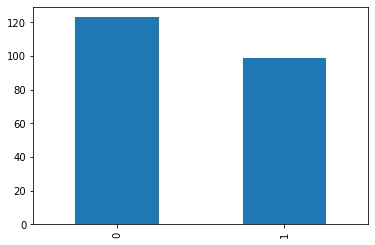

In [20]:
new_data["label"].value_counts().plot.bar();

$\to$ số lượng giá trị của mỗi label không chênh lệch nhau nhiều lắm.

- Xem sét độ dài của mỗi văn bản trong cột `text`

In [21]:
new_data["text"].apply(len).to_frame().agg([min, max])

,text
min,161
max,5272


- Visualize độ dài của các văn bản trong cột `text`

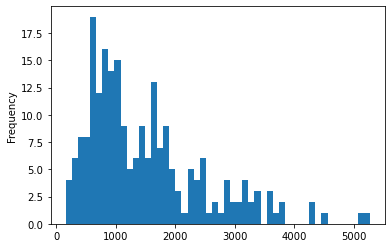

In [22]:
new_data["text"].apply(len).plot.hist(bins=50);

# Mô hình hóa

## Multinomial NB

### Đọc dữ liệu từ file .csv vào

In [23]:
new_data = pd.read_csv("dataset_after.csv", sep='\t')

In [24]:
new_data.head()

,text,domain,label
0,thủ_tướng abe cúi đầu xin_lỗi hành_động phi th...,binhluan.biz,1
1,thủ_tướng nhật cúi đầu xin_lỗi tinh_thần phi t...,www.ipick.vn,1
2,choáng cơ_trưởng đeo khăn_quàng quẩy banh sân_...,tintucqpvn.net,1
3,nhạc kpop hát giáo_sư nguyễn_lân_dũng ‘ thành_...,tintucqpvn.net,1
4,đại_học hutech áp_dụng cải_cách tiếq việt năm_...,www.gioitreviet.net,1


### Chia tập test và train

In [25]:
X_train, X_test, y_train, y_test = train_test_split(new_data['text'].values, new_data['label'].values, test_size=0.3, random_state=42)

### Huấn luyện mô hình

- Tạo 1 `pipeline` gồm 2 bước:
    - Vetorization
    - model

In [26]:
mnbc = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [27]:
start_time = time.time()
mnbc.fit(X_train, y_train)
end_time = time.time()
labels = mnbc.predict(X_test)
score = metrics.accuracy_score(y_test,labels)
cv_score_mean = cross_val_score(mnbc, new_data['text'].values, new_data['label'].values, cv=10).mean()

In [28]:
print("Multinomial:")
print('Train time: ', round((end_time - start_time),3))
print('Model training score: ' + str(round(score,3)))
print("Average cross validation score: ", round(cv_score_mean,3))

Multinomial:
Train time:  0.153
Model training score: 0.91
Average cross validation score:  0.858


### Save model lại

In [29]:
joblib.dump(mnbc,'mnbc.mdl')

['mnbc.mdl']

### Import model đã được lưu

In [30]:
test_model = joblib.load('mnbc.mdl')

In [31]:
labels_test = test_model.predict(X_test)

In [32]:
score_test = metrics.accuracy_score(y_test,labels_test)

In [33]:
print(score_test)

0.9104477611940298


## SGD Classifier

### Đọc dữ liệu từ file .csv vào

In [34]:
new_data = pd.read_csv("dataset_after.csv", sep='\t')

In [35]:
new_data.head()

,text,domain,label
0,thủ_tướng abe cúi đầu xin_lỗi hành_động phi th...,binhluan.biz,1
1,thủ_tướng nhật cúi đầu xin_lỗi tinh_thần phi t...,www.ipick.vn,1
2,choáng cơ_trưởng đeo khăn_quàng quẩy banh sân_...,tintucqpvn.net,1
3,nhạc kpop hát giáo_sư nguyễn_lân_dũng ‘ thành_...,tintucqpvn.net,1
4,đại_học hutech áp_dụng cải_cách tiếq việt năm_...,www.gioitreviet.net,1


### Chia tập test và train

In [36]:
X_train, X_test, y_train, y_test = train_test_split(new_data['text'].values, new_data['label'].values, test_size=0.3, random_state=42)

### Huấn luyện mô hình

- Tạo 1 `pipeline` gồm 2 bước:
    - Vetorization
    - model

In [37]:
SGDC = make_pipeline(TfidfVectorizer(), SGDClassifier())

In [38]:
start_time = time.time()
SGDC.fit(X_train, y_train)
end_time = time.time()
labels = SGDC.predict(X_test)
score = metrics.accuracy_score(y_test,labels)
cv_score_mean = cross_val_score(SGDC, new_data['text'].values, new_data['label'].values, cv=10).mean()

In [39]:
print("SGD Classifier:")
print('Train time: ', round((end_time - start_time),3))
print('Model training score: ' + str(round(score,3)))
print("Average cross validation score: ", round(cv_score_mean,3))

SGD Classifier:
Train time:  0.155
Model training score: 0.791
Average cross validation score:  0.875


### Save model lại

In [40]:
joblib.dump(SGDC,'sgdc.mdl')

['sgdc.mdl']

### Import model đã được lưu

In [41]:
test_model = joblib.load('sgdc.mdl')

In [42]:
labels_test = test_model.predict(X_test)

In [43]:
score_test = metrics.accuracy_score(y_test,labels_test)

In [44]:
print(score_test)

0.7910447761194029


## Random Forest Classifier

### Đọc dữ liệu từ file .csv vào

In [45]:
new_data = pd.read_csv("dataset_after.csv", sep='\t')

In [46]:
new_data.head()

,text,domain,label
0,thủ_tướng abe cúi đầu xin_lỗi hành_động phi th...,binhluan.biz,1
1,thủ_tướng nhật cúi đầu xin_lỗi tinh_thần phi t...,www.ipick.vn,1
2,choáng cơ_trưởng đeo khăn_quàng quẩy banh sân_...,tintucqpvn.net,1
3,nhạc kpop hát giáo_sư nguyễn_lân_dũng ‘ thành_...,tintucqpvn.net,1
4,đại_học hutech áp_dụng cải_cách tiếq việt năm_...,www.gioitreviet.net,1


### Chia tập test và train

In [47]:
X_train, X_test, y_train, y_test = train_test_split(new_data['text'].values, new_data['label'].values, test_size=0.3, random_state=42)

### Huấn luyện mô hình

- Tạo 1 `pipeline` gồm 2 bước:
    - Vetorization
    - model

In [48]:
model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

- Xem tên của các **Hyperparameter**

In [49]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidfvectorizer', 'randomforestclassifier', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer__norm', 'tfidfvectorizer__preprocessor', 'tfidfvectorizer__smooth_idf', 'tfidfvectorizer__stop_words', 'tfidfvectorizer__strip_accents', 'tfidfvectorizer__sublinear_tf', 'tfidfvectorizer__token_pattern', 'tfidfvectorizer__tokenizer', 'tfidfvectorizer__use_idf', 'tfidfvectorizer__vocabulary', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestcl

Chọn ra các **Hyperparameter** cần tuning:
- randomforestclassifier__bootstrap
- randomforestclassifier__n_estimators
- randomforestclassifier__max_depth
- randomforestclassifier__max_features
- randomforestclassifier__min_samples_leaf
- randomforestclassifier__min_samples_split

In [50]:
params = {
    "randomforestclassifier__bootstrap": [True, False],
    "randomforestclassifier__n_estimators": [100, 200, 400, 600, 800, 1000, 1200, 1400],
    "randomforestclassifier__max_depth": [10, 20, 30, 50, 60, 100],
    "randomforestclassifier__max_features": ["auto", "sqrt"],
    "randomforestclassifier__min_samples_leaf": [1, 2, 3, 4],
    "randomforestclassifier__min_samples_split": [1, 2, 3, 4, 5, 6]
}

In [51]:
search = RandomizedSearchCV(estimator=model,\
                           param_distributions=params,\
                           n_iter=10,\
                           n_jobs=-1,\
                           verbose=10)

- Tiến hành quá trình tuning

In [52]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


D:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.83870968 0.87741935 0.85806452 0.89032258 0.8516129  0.88387097
 0.89032258        nan 0.87096774 0.88387097]
  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__max_depth': [10,
                                                                              20,
                                                                              30,
                                                                              50,
                                                                              60,
                                                                              100],
                            

- lưu các `Hyperparameter` tốt nhất lại để set cho `model`

In [53]:
best_params = search.best_params_

In [54]:
model.set_params(**best_params)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=50, max_features='sqrt',
                                        min_samples_leaf=3, min_samples_split=4,
                                        n_estimators=1400))])

In [55]:
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()

In [56]:
y_pred = model.predict(X_test)

In [57]:
test_score = metrics.accuracy_score(y_test, y_pred)
cv_score_mean = cross_val_score(model, new_data["text"].values, new_data["label"].values, cv=10).mean()

In [58]:
print("Random Forest Classifier")
print("Training time: {}s".format(round(end_time - start_time, 3)))
print("Accuracy on Test Set: {}".format(round(test_score, 3)))
print("Average cross Validation Score: {}".format(round(cv_score_mean, 3)))

Random Forest Classifier
Training time: 1.839s
Accuracy on Test Set: 0.866
Average cross Validation Score: 0.867


### Save model để lại

In [59]:
joblib.dump(model, "rdfc.mdl")

['rdfc.mdl']

### Import model đã được lưu

In [61]:
rdfc = joblib.load("rdfc.mdl")

In [62]:
y_pred = rdfc.predict(X_test)

In [63]:
test_score = metrics.accuracy_score(y_pred, y_test)

In [64]:
print("Saved model's Accuracy in test set: {}".format(test_score))

Saved model's Accuracy in test set: 0.8656716417910447


In [70]:
def preprocess_text(text):
     text = text.strip()
     with open('stopwords.txt','r',encoding='utf-8') as stopfin:
          stopwords = stopfin.readlines()
          for i in range(len(stopwords)):
               stopwords[i] = word_tokenize(stopwords[i].strip(), format = 'text')
          
     patweb = '[http\:\/\/|https\:\/\/]+[www\.]*\w+\.[\w+.|\w+\/\w+\-?%&=]+'

     special_char = ['@','#', '/','!','.',',','\\','\'','"','+','-','=',':',';','...','(',')','“','”']

     after_processed = []
     text = word_tokenize(text,format = 'text').split(' ')
     for word in text:
          word = word.lower()
          url = re.findall(patweb,word)
          if  word not in special_char:
               if word not in url:
                    if word not in stopwords:
                         after_processed.append(word)
     text_after = ' '.join(after_processed)

     return text_after

In [86]:
news = """Thủ tướng Abe cúi đầu xin lỗi vì hành động phi thể thao của tuyển Nhật
Theo Sankei Sports, sáng nay Thủ tướng Nhật Bản Shinzo Abe công khai gửi lời xin lỗi tới Nhật hoàng và toàn bộ người dân vì tinh thần thi đấu phi thể thao của đội tuyển Nhật tại World Cup 2018."""

In [87]:
txt = [preprocess_text(news)]

In [89]:
TfidfVectorizer().fit_transform(txt)

<1x22 sparse matrix of type '<class 'numpy.float64'>'
	with 22 stored elements in Compressed Sparse Row format>